# Import Libraries

In [64]:
import spacy
import os
import json
import pandas as pd
import pickle
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.http import MediaIoBaseDownload
from bs4 import BeautifulSoup
import requests
import random
from spacy.training import Example
from spacy.util import minibatch, compounding
import io
import re
import datetime

# Data Collection

--------

In [65]:
# if csv exists, load it
if os.path.exists('../clean_data/medications.csv'):
    medications = pd.read_csv('../clean_data/medications.csv')
# otherwise, scrape the data
else:
    url = "https://healthy.kaiserpermanente.org/health-wellness/drug-encyclopedia."

    medications = []

    # iterate from 'a' to 'z'
    for letter in range(97, 123):
        url = url + chr(letter)
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for li in soup.select(".drug-column-4"):
            medications.append(li.text)
        
        url = "https://healthy.kaiserpermanente.org/health-wellness/drug-encyclopedia."

    # split by new line
    medications = [medication.split('\n') for medication in medications]
    # flatten and remove empty strings
    medications = [medication for sublist in medications for medication in sublist if medication != '']
    medications = pd.DataFrame(medications, columns=['medication'])
    medications.to_csv('../clean_data/medications.csv', index=False)


print(medications.head())

      medication
0  acetaminophen
1      acyclovir
2       Adderall
3      albuterol
4    alendronate


380 medication names to randomize NER data

In [66]:
# Define the scope of the application
SCOPES = ['https://www.googleapis.com/auth/drive']
# Function to authenticate and create the service
def create_service():
    creds = None
    # The file token.pickle stores the user's access and refresh tokens.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    
    service = build('drive', 'v3', credentials=creds)
    return service

# Function to list files in a given folder ID
def list_files_in_folder(service, folder_id):
    results = service.files().list(q=f"'{folder_id}' in parents", fields="nextPageToken, files(id, name)").execute()
    items = results.get('files', [])
    return items

# Function to download a file
def download_or_export_file(service, file_id, file_name, mime_type):
    try:
        # Check if the file is a Google Doc by its MIME type
        if mime_type.startswith('application/vnd.google-apps.'):
            # Define export MIME type for Google Docs (e.g., 'application/pdf' for Google Docs)
            if mime_type == 'application/vnd.google-apps.document':
                export_mime_type = 'application/pdf'
                file_name += '.pdf'  # Append appropriate file extension
            elif mime_type == 'application/vnd.google-apps.spreadsheet':
                export_mime_type = 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet'
                file_name += '.xlsx'  # Append appropriate file extension
            elif mime_type == 'application/vnd.google-apps.presentation':
                export_mime_type = 'application/vnd.openxmlformats-officedocument.presentationml.presentation'
                file_name += '.pptx'  # Append appropriate file extension
            else:
                # Default to PDF for other Google Apps documents
                export_mime_type = 'application/pdf'
                file_name += '.pdf'
            
            request = service.files().export_media(fileId=file_id, mimeType=export_mime_type)
        else:
            # For binary files, use the get_media method
            request = service.files().get_media(fileId=file_id)
        
        # Perform the download or export
        fh = io.BytesIO()
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            print(f"Download {int(status.progress() * 100)}%.")
        
        # Write the file's contents to a local file
        with open(file_name, 'wb') as f:
            f.write(fh.getbuffer())
        print(f"File '{file_name}' downloaded successfully.")
    
    except Exception as e:
        print(f"An error occurred: {e}")

def find_folders_by_name(service, folder_name):
    """Find folders by name and return their IDs."""
    query = f"mimeType='application/vnd.google-apps.folder' and name='{folder_name}'"
    response = service.files().list(q=query, spaces='drive', fields='files(id, name)').execute()
    return response.get('files', [])

def find_subfolder_id(service, parent_folder_id, subfolder_name):
    """Find a specific subfolder within a parent folder."""
    query = f"'{parent_folder_id}' in parents and mimeType='application/vnd.google-apps.folder' and name='{subfolder_name}'"
    response = service.files().list(q=query, spaces='drive', fields='files(id, name)').execute()
    files = response.get('files', [])
    if files:
        return files[0]['id']  # Return the ID of the first matching subfolder
    return None

def download_txt_files_from_folder(service, folder_id):
    """Download all .txt files from a specified folder."""
    query = f"'{folder_id}' in parents and mimeType='text/plain'"
    response = service.files().list(q=query, spaces='drive', fields='files(id, name, mimeType)').execute()
    files = response.get('files', [])
    for file in files:
        print(f"Downloading/exporting {file['name']}...")
        download_or_export_file(service, file['id'], file['name'], file['mimeType'])

Toy diagnosis data. Might look into a better source, but this will work for now

In [67]:
# again, if csv exists, load it
if os.path.exists('../clean_data/diagnoses.csv'):
    diagnoses = pd.read_csv('../clean_data/diagnoses.csv')
# otherwise, download it from Google Drive
else:
    service = create_service()  # Assume this is implemented as shown before
    top_level_folder_names = ['Base-Game', 'Mod-Diagnoses']

    for folder_name in top_level_folder_names:
        folders = find_folders_by_name(service, folder_name)
        for folder in folders:
            dept_diagnoses_folder_id = find_subfolder_id(service, folder['id'], 'Dept-Diagnoses')
            if dept_diagnoses_folder_id:
                download_txt_files_from_folder(service, dept_diagnoses_folder_id)
    
    diagnoses = []
    # loop through all files and extract the text following '##' (diagnosis names)
    for file in os.listdir('../raw_data/diagnoses'):
        with open(f'../raw_data/diagnoses/{file}', 'r') as f:
            for line in f:
                if '##' in line:
                    diagnoses.append(line.split('##')[1].strip())
    
    diagnoses = pd.DataFrame(diagnoses, columns=['diagnosis']).to_csv('../clean_data/diagnoses.csv', index=False)

print(diagnoses.head())

                               diagnosis
0                Acute Myeloid Leukaemia
1   Adrenocortical Carcinoma (Localised)
2  Adrenocortical Carcinoma (Metastatic)
3    Adrenocortical Carcinoma (Regional)
4                           ALL (B Cell)


634 diagnoses to randomize NER training data

Some dosages are nonsensical, but will hopefully allow the model to generalize well

In [68]:
# randomly generate dosage data
dosages = []
units = ['mg', 'g', 'mL', 'L']
concat_every = 5
frequency = ['twice daily', 'once daily', 'as needed']

for hour in range(48):
    frequency.append(f'every {hour} hours')

for i in range(300):
    dosage = str(random.choice(range(5, 1001, 5))) + f' {random.choice(units)}'
    if i % concat_every == 0:
        dosage += ' ' + random.choice(frequency)
    dosages.append(dosage)

print(dosages)

['685 mL every 10 hours', '410 mg', '860 mL', '25 g', '210 mL', '685 L every 21 hours', '905 mL', '565 mL', '510 mL', '570 mg', '120 g every 1 hours', '270 L', '820 mL', '250 g', '505 mg', '410 g every 43 hours', '10 g', '770 mL', '985 L', '510 mg', '835 mL every 45 hours', '230 g', '95 mL', '130 g', '935 mL', '385 g every 26 hours', '745 mL', '215 mL', '375 L', '90 g', '230 mL every 19 hours', '625 L', '580 mg', '805 L', '250 L', '30 g every 5 hours', '760 L', '155 mL', '825 mg', '985 mL', '355 mL every 22 hours', '670 mL', '145 mg', '425 L', '390 mg', '395 mL every 40 hours', '260 mL', '965 g', '510 mL', '305 mL', '465 L every 11 hours', '825 mg', '345 mL', '120 mL', '845 mg', '105 mg every 6 hours', '45 mL', '490 mg', '275 g', '745 mg', '300 mg twice daily', '615 g', '605 L', '505 g', '730 g', '500 g twice daily', '140 L', '240 g', '975 mg', '5 g', '615 mg every 14 hours', '345 mL', '975 g', '730 mg', '120 L', '860 mL every 34 hours', '110 mL', '740 mg', '300 mg', '240 mL', '845 mg 

Tests

In [69]:
# if csv exists, load it
if os.path.exists('../clean_data/tests.csv'):
    tests = pd.read_csv('../clean_data/tests.csv')
# otherwise, scrape the data
else:
    url = "https://medlineplus.gov/lab-tests/"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tests = []
    # select all uorderdered lists with class 'withident breaklist'
    for item in soup.select(".withident.breaklist"):
        tests.append(item.text)

    tests = pd.DataFrame(tests, columns=['test'])
    tests['test'] = tests['test'].str.split('\n')
    tests = tests.explode('test')
    tests = tests[tests['test'] != '']
    tests.to_csv('../clean_data/tests.csv', index=False)

Symptoms

In [70]:
# if csv exists, load it
if os.path.exists('../clean_data/symptoms.csv'):
    symptoms = pd.read_csv('../clean_data/symptoms.csv')
else:
    symptoms = []
    pattern = r"\+\s(.+?)\s\(\d+% of cases \| .+?\)"

    # loop through all files and extract the text following '##' (diagnosis names)
    for file in os.listdir('../raw_data/diagnoses'):
        with open(f'../raw_data/diagnoses/{file}', 'r') as f:
            for line in f:
                match = re.search(pattern, line)
                if match:
                    symptoms.append(match.group(1))

    symptoms = pd.DataFrame(symptoms, columns=['symptom'])
    # make unique
    symptoms = symptoms.drop_duplicates()
    symptoms.to_csv('../clean_data/symptoms.csv', index=False)

Dates

In [71]:
dates = []

# generate dates in the format "Month Day"
for i in range(1, 13):
    for j in range(1, 29):
        # year is arbitrary
        date = datetime.date(2021, i, j)
        full_date = f"{date.strftime('%B')} {date.strftime('%d')}"
        dates.append(full_date)

print(dates)

['January 01', 'January 02', 'January 03', 'January 04', 'January 05', 'January 06', 'January 07', 'January 08', 'January 09', 'January 10', 'January 11', 'January 12', 'January 13', 'January 14', 'January 15', 'January 16', 'January 17', 'January 18', 'January 19', 'January 20', 'January 21', 'January 22', 'January 23', 'January 24', 'January 25', 'January 26', 'January 27', 'January 28', 'February 01', 'February 02', 'February 03', 'February 04', 'February 05', 'February 06', 'February 07', 'February 08', 'February 09', 'February 10', 'February 11', 'February 12', 'February 13', 'February 14', 'February 15', 'February 16', 'February 17', 'February 18', 'February 19', 'February 20', 'February 21', 'February 22', 'February 23', 'February 24', 'February 25', 'February 26', 'February 27', 'February 28', 'March 01', 'March 02', 'March 03', 'March 04', 'March 05', 'March 06', 'March 07', 'March 08', 'March 09', 'March 10', 'March 11', 'March 12', 'March 13', 'March 14', 'March 15', 'March 

Times

In [72]:
times = []
# generate times in the format "Hour AM/PM"
for i in range(1, 13):
    for j in ["AM", "PM"]:
        time = f"{i} {j}"
        times.append(time)

Body parts

Hard-coding for now. Will change

In [73]:
anatomies = ["left femur", "right knee", "abdominal region", "left lung", "right lung", "left kidney", "right kidney",
             "left eye", "right eye", "left ear", "right ear", "left hand", "right hand", "left foot", "right foot",
             "left arm", "right arm", "left leg", "right leg", "left shoulder", "right shoulder", "left hip", "right hip",
             "left elbow", "right elbow", "left wrist", "right wrist", "left ankle", "right ankle", "left toe", "right toe",
             "left finger", "right finger", "left thumb", "right thumb", "left nostril", "right nostril", "left cheek", "right cheek",
             "left temple", "right temple", "left jaw", "right jaw", "left chin", "right chin", "left neck", "right neck", "left collarbone",
             "right collarbone", "left rib", "right rib", "left hip bone", "right hip bone", "left thigh", "right thigh", "left calf",
             "right calf", "left shin", "right shin", "left heel", "right heel", "left sole", "right sole", "left toe", "right toe",
             "left finger", "right finger", "left thumb", "right thumb", "left palm", "right palm", "left wrist", "right wrist", "left forearm",
             "right forearm", "left bicep", "right bicep", "left tricep", "right tricep", "left shoulder", "right shoulder", "left chest", "right chest",
             "left breast", "right breast", "left nipple", "right nipple", "left rib", "right rib", "left abdomen", "right abdomen", "left hip",
             "right hip", "left groin", "right groin", "left thigh", "right thigh", "left knee", "right knee", "left shin", "right shin", "left calf",
             "right calf", "left ankle", "right ankle", "left foot", "right foot", "left toe", "right toe", "left finger", "right finger", "left thumb",
             "right thumb", "left hand", "right hand", "left wrist", "right wrist", "left forearm", "right forearm", "left elbow", "right elbow",
             "left upper arm", "right upper arm", "left shoulder", "heart", "liver", "stomach", "intestines", "pancreas", "spleen", "bladder", "esophagus"]

len(anatomies)

132

In [74]:
# make unique
anatomies = list(set(anatomies))
len(anatomies)

92

-------------------

# Data Processing

---------

ToDo: Need to combine logic of next two cells to only generate a train_data.csv instead of two files

In [75]:
# Function to generate a random date
def generate_example():
    output = {}
    genders = ['he', 'she', 'they', 'the patient'] # for variation
    diagnosis = random.choice(diagnoses['diagnosis'].values)
    medication = random.choice(medications['medication'].values)
    dosage = random.choice(dosages)
    test_name = random.choice(tests['test'].values)
    symptom = random.choice(symptoms['symptom'].values)
    body_part = random.choice(anatomies)
    gender = random.choice(genders)

    choices = [diagnosis, medication, dosage, test_name, symptom, body_part]
    choice_map = ['diagnosis', 'medication', 'dosage', 'test_name', 'symptom', 'body_part']
    entities = []

    text_elements = [
        f"{gender.capitalize()} was diagnosed with {diagnosis} last year.",
        f"{gender.capitalize()} has been prescribed {medication} {dosage}.",
        f"{test_name.capitalize()} measurements indicate {diagnosis}.",
        f"The {test_name} revealed a {diagnosis} in the {body_part}.",
        f"Patient presents with {symptom}.",
        f"Prescribe {dosage} of {medication} for pain relief.",
        f"The {test_name} shows normal {body_part} function.",
        f"{gender.capitalize()} mentioned an allergy to {medication}.",
        f"Examine the {symptom} in the patient's {body_part}.",
    ]
    text = random.choice(text_elements)
    annotated_segments = []
    for index, choice in enumerate(choices):
        start_pos = text.find(choice)
        if start_pos != -1 and not any(start <= start_pos < end for start, end in annotated_segments):
            end_pos = start_pos + len(choice)
            entities.append({"start": start_pos, "end": end_pos, "label": choice_map[index]})
            annotated_segments.append((start_pos, end_pos))
    
    output["text"] = text
    output["entities"] = entities
    return output

# Generate 1000 examples
train_data = [generate_example() for _ in range(1000)]

# Save the examples to a JSON file
file_path = '../clean_data/train_data.json'
with open(file_path, 'w') as file:
    json.dump(train_data, file, indent=2)

In [76]:
# Load JSON data
with open('../clean_data/train_data.json', 'r') as file:
    data = json.load(file)

# Convert the JSON data to the desired format
formatted_data = []
for item in data:
    text = item['text']
    entities = []
    for entity in item['entities']:
        start = entity['start']
        end = entity['end']
        label = entity['label']
        entities.append((start, end, label.upper()))  # Convert label to uppercase as shown in the example
    formatted_data.append((text, {"entities": entities}))

In [77]:
from sklearn.model_selection import train_test_split

# Split data into training and test set
train, test = train_test_split(formatted_data, test_size=0.2, random_state=42)

In [78]:
entity_labels = set()
for text, annotations in formatted_data:
    for entity in annotations['entities']:
        entity_labels.add(entity[2])

print(entity_labels)

{'MEDICATION', 'SYMPTOM', 'BODY_PART', 'DOSAGE', 'TEST_NAME', 'DIAGNOSIS'}


---

In [79]:
retrain = True # Set to True to retrain the model

if os.path.exists('../clean_data/models/ner_model') and not retrain:
    nlp = spacy.load('../clean_data/models/ner_model')
else:
    # Load a blank model
    # nlp = spacy.blank('en')

    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load('en_core_web_sm') # use a pre-trained model

    # Add the NER pipeline if not already present
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe('ner')
    else:
        ner = nlp.get_pipe('ner')

    # Add entity labels to the model
    for entity in entity_labels:
        ner.add_label(entity)

    optimizer = nlp.resume_training()
    for itn in range(10):  # Number of training iterations
        losses = {}
        for batch in minibatch(train, size=compounding(4.0, 32.0, 1.001)):
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update([example], drop=0.5, sgd=optimizer, losses=losses)
        print("Losses", losses)

    # Save the model
    nlp.to_disk('../clean_data/models/ner_model')

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/home/riley/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "She has been prescribed metoprolol 345 mL." with entities "[(24, 34, 'MEDICATION'), (35, 41, 'DOSAGE')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/riley/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "He has been prescribed orphenadrine 515 g." with entities "[(23, 35, 'MEDICATION'), (36, 41, 'DOSAGE')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/riley/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the t

Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1607.8930436371982}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 779.3199609727022}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 377.77889064761905}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 268.74825316583025}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 185.9490256106869}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 117.76420694941555}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 91.95857826127126}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 96.72885870211049}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 134.27374156426438}
Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 82.72161316067051}


Will need more rigorous testing/improvement im sure, but fine for now

In [80]:
# Example text
text = "Patient was administered 500mg of Ibuprofen."

# Process the text
doc = nlp(text)

# Iterate over the predicted entities
for ent in doc.ents:
    print(ent.text, ent.label_)

500mg DOSAGE
Ibuprofen MEDICATION


In [81]:
from spacy.training import Example

# Load the test data
examples = []
for text, annotations in test:
    doc = nlp.make_doc(text)
    examples.append(Example.from_dict(doc, annotations))

# Evaluate the model
scores = nlp.evaluate(examples)
print(f"Precision: {scores['ents_p']:.3f}")
print(f"Recall: {scores['ents_r']:.3f}")
print(f"F1 Score: {scores['ents_f']:.3f}")

/home/riley/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "They has been prescribed Eldoquin 615 g." with entities "[(25, 33, 'MEDICATION'), (34, 39, 'DOSAGE')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/riley/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "They has been prescribed furosemide 915 g." with entities "[(25, 35, 'MEDICATION'), (36, 41, 'DOSAGE')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/riley/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the tex

Precision: 0.985
Recall: 0.985
F1 Score: 0.985


In [82]:
def calculate_accuracy(examples, model):
    correct_predictions = 0
    total_entities = 0

    for example in examples:
        # Process the text to predict entities
        doc = model(example.text)
        true_ents = set((ent.start_char, ent.end_char, ent.label_) for ent in example.reference.ents)
        pred_ents = set((ent.start_char, ent.end_char, ent.label_) for ent in doc.ents)
        
        # Calculate matches
        correct_predictions += len(true_ents.intersection(pred_ents))
        total_entities += len(true_ents)
        
    if total_entities == 0:
        return 0.0
    accuracy = correct_predictions / total_entities
    return accuracy

# Assuming 'examples' is a list of spaCy Example objects
accuracy = calculate_accuracy(examples, nlp)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.985


In [83]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

entity_labels = list(entity_labels)

# Assume entity_labels is a list of all entity labels in the dataset
label_indices = {label: idx for idx, label in enumerate(entity_labels)}
num_labels = len(entity_labels)

# Initialize the confusion matrix
conf_matrix = np.zeros((num_labels, num_labels), dtype=int)

# Assume examples is your validation/test set
for example in examples:
    true_ents = [(ent.start_char, ent.end_char, ent.label_) for ent in example.reference.ents]
    doc = nlp(example.text)
    pred_ents = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

    # Map predicted entities to true entities and increment the confusion matrix
    for true_ent in true_ents:
        true_label_idx = label_indices[true_ent[2]]
        # Check if the true entity is in the predictions
        if true_ent in pred_ents:
            pred_label_idx = true_label_idx
        else:
            # If not, find a matching span with a different label, or no entity
            pred_label_idx = label_indices.get(next((pe[2] for pe in pred_ents if pe[0] == true_ent[0] and pe[1] == true_ent[1]), 'O'), num_labels - 1)
        conf_matrix[true_label_idx, pred_label_idx] += 1

    # Check for false positives
    for pred_ent in pred_ents:
        if pred_ent not in true_ents:
            pred_label_idx = label_indices[pred_ent[2]]
            conf_matrix[-1, pred_label_idx] += 1  # 'O' row

# Now `conf_matrix` contains the confusion matrix
# Optionally, convert it to a DataFrame for better readability
df_conf_matrix = pd.DataFrame(conf_matrix, index=entity_labels, columns=entity_labels)

print(df_conf_matrix)

            MEDICATION  SYMPTOM  BODY_PART  DOSAGE  TEST_NAME  DIAGNOSIS
MEDICATION          66        0          0       0          0          1
SYMPTOM              0       43          0       0          0          0
BODY_PART            0        0         64       0          0          2
DOSAGE               0        0          0      36          0          0
TEST_NAME            0        0          0       0         45          0
DIAGNOSIS            0        1          2      13          0         79


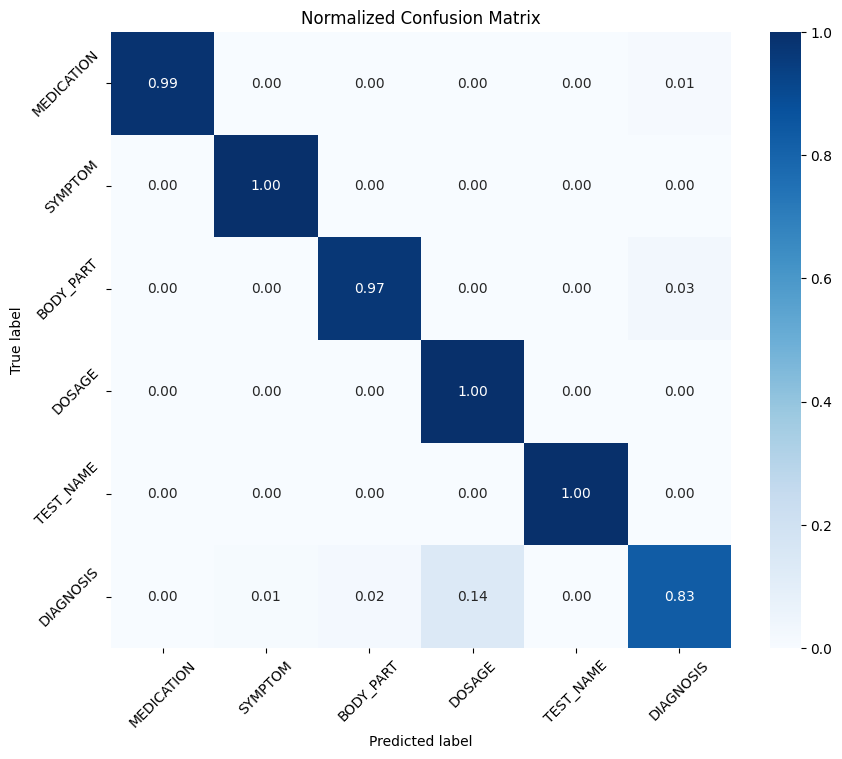

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the confusion matrix
df_conf_matrix_normalized = df_conf_matrix.div(df_conf_matrix.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(df_conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=df_conf_matrix.columns, yticklabels=df_conf_matrix.index)

plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45)  # Rotate the x labels to fit longer names, if necessary
plt.yticks(rotation=45)  # Rotate the y labels for consistency

plt.show()

In [85]:
from spacy import displacy

example_text = test[0][0]
doc = nlp(example_text)
displacy.render(doc, style="ent", jupyter=True)